# Model to predict crash propensity from intersection features in Iowa
This notebook will train a deep machine learning model and apply its predictions onto the Iowa case study dataset.

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import psycopg2
from geopy.distance import distance as geo_distance
import geopandas as gpd
import pdb
import matplotlib as mpl
import seaborn as sns

mpl.rcParams['axes.linewidth'] = 3
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

# Analysis idea:

Loop over each intersection. Extract the num crashes within a certain radius. Calculate the number of crashes per yea for each unique intersection. Use a decision tree that uses a gini index on just the num-legs, angle data or some other simple model As we gather more quality feature data more sophisticated methods can replace the decision tree. Use the standard deviation of poisson distribution to calculate the confidence interval.

In [32]:
POSTGRES_DB= 'rws'
POSTGRES_PASSWORD= 'ug_password'
POSTGRES_USER= 'ug_username'
CURRENT_DIR= os.getcwd()
    
conn = psycopg2.connect(f"host=localhost dbname={POSTGRES_DB} user={POSTGRES_USER} password={POSTGRES_PASSWORD} port=5433")


In [33]:
sql_full = f"""
SELECT 
  ni.node_id,
  ni.point3857,
  ni.lat,
  ni.long,
  ni.legs,
  int_feat.way_lines,
  int_feat.ramp_roads,
  int_feat.bikepaths,
  int_feat.footways,
  int_feat.oneways,
  int_feat.maxspeed,
  int_feat.minspeed,
  int_feat.surface_types,
  int_feat.aadt,
  int_feat.min_angle,
  int_feat.second_min_angle,
  int_feat.junction_geometry_type_id,
  int_feat.junction_type_id,
  sum(cast(
  case
        when length(wfv.lanes)>2 then null
        when wfv.lanes is null then null
        when wfv.lanes = '' then null
        else wfv.lanes
    end
    as int
  )) as num_lanes,
 mode() WITHIN GROUP (ORDER BY wfv.highway) AS  highway_type
from 
  rws.iowa.node_intersections ni 
inner join 
  rws.iowa.intersection_features int_feat  on int_feat.node_id=ni.node_id 
 join 
  rws.iowa.curated_way_feature_view wfv on wfv.node_id=ni.node_id  

group by 
  ni.node_id,
  ni.point3857,
  ni.lat,
  ni.long,
  ni.legs,
  int_feat.way_lines,
  int_feat.ramp_roads,
  int_feat.bikepaths,
  int_feat.footways,
  int_feat.oneways,
  int_feat.maxspeed,
  int_feat.minspeed,
  int_feat.surface_types,
  int_feat.aadt,
  int_feat.min_angle,
  int_feat.second_min_angle,
  int_feat.junction_geometry_type_id,
  int_feat.junction_type_id;
"""

df = gpd.read_postgis(sql_full,
                      conn,
                      geom_col="point3857")

/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [34]:
df.sort_values('aadt',ascending=False).head(5)

,node_id,point3857,lat,long,legs,way_lines,ramp_roads,bikepaths,footways,oneways,maxspeed,minspeed,surface_types,aadt,min_angle,second_min_angle,junction_geometry_type_id,junction_type_id,num_lanes,highway_type
11566,158976143,POINT (-10263930.240 5172376.232),42.076037,-92.202454,3,0105000020110F00000300000001020000000200000032...,0,0,0,0,None,None,[asphalt],5102021.0,84.254445,95.772991,1.0,1,NaN,service
29615,159107460,POINT (-10263932.289 5170805.229),42.065561,-92.202472,3,0105000020110F000003000000010200000002000000F6...,0,0,0,0,None,None,"[asphalt, gravel]",5102021.0,89.705603,90.535118,1.0,1,NaN,residential
227022,160782585,POINT (-10428298.511 5099945.097),41.591244,-93.678999,3,0105000020110F000003000000010200000002000000E9...,1,0,0,3,60 mph,60 mph,[asphalt],139000.0,6.059001,176.160547,NaN,2,4.0,motorway
241471,160909686,POINT (-10429267.592 5100085.739),41.592189,-93.687705,3,0105000020110F00000300000001020000000200000015...,1,0,0,3,60 mph,60 mph,[asphalt],139000.0,7.894705,172.049990,NaN,2,4.0,motorway
224982,160760385,POINT (-10427437.410 5100053.901),41.591975,-93.671264,3,0105000020110F000003000000010200000002000000E3...,1,0,0,3,60 mph,60 mph,[asphalt],134700.0,18.327115,161.327017,NaN,2,9.0,motorway


# The following code build a dataset of historical crash data

In [35]:
sql_crashes = f"""SELECT *,ST_AsText(iowa.point) as t_point from rws.iowa.crashes as iowa """

df_crashes = gpd.read_postgis(sql_crashes, conn,geom_col="point")

/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


In [36]:
df_crashes.head()

,node_id,point,the_geom,objectid,crash_key,case_number_iowa_dot,law_enforcement_case_number,date_of_crash,month_of_crash,day_of_week,time_of_crash,dot_district,county_number,city_number,route_with_system,derived_literal_description,first_harmful_event,location_of_first_harmful_event,manner_of_crash_collision,major_cause,drug_or_alcohol_related,contributing_circumstances_environment,light_conditions,surface_conditions,weather_conditions,contributing_circumstances_roadway,type_of_roadway_junction_feature,paved_or_not,work_zone_related,crash_severity,number_of_fatalities,number_of_injuries,number_of_major_injuries,number_of_minor_injuries,number_of_possible_injuries,number_of_unknown_injuries,amount_of_property_damage,number_of_vehicles_involved,total_number_of_occupants,report_type,x_coordinate,y_coordinate,rest_service_last_updated,rest_service_utc_offset,crash_date_time_local,crash_date_time_utc,crash_date_time_utc_offset,city_name,county_name,direction,globalid,t_point
0,-1,POINT (-10085665.820 5092061.160),POINT (-90.60107756538 41.538254176651),3099357,2013005342,2013726799,2013-11719,02/18/2013 12:00:00 AM +0000,2,2,20:33,6,82,None,None,W LOCUST ST & HICKORY GROVE RD & N DIVISION ST,33,1,6,71,8,2,4,3,7,2,1,1,None,5,0,0,0,0,0,0,3500,2,3,7,700110,4601290,10/19/2020 06:32:56 PM +0000,None,None,None,None,None,None,None,8f7d4562-1d44-4588-ae14-1cb55cc3824a,POINT(-10085665.819899984 5092061.160419996)
1,-1,POINT (-10470862.084 5049405.372),POINT (-94.061354475179 41.250800584789),3216291,2011028220,2011643133,067-11,08/13/2011 12:00:00 AM +0000,8,7,10:30,4,61,None,None,Co Rd G53/CARVER RD/275TH ST,33,1,5,3,8,1,1,1,1,1,13,2,None,5,0,0,0,0,0,0,9000,2,5,7,411077,4567142,10/19/2020 06:32:56 PM +0000,None,None,None,None,None,None,None,60da76c3-b3ad-47d9-b0c1-7d5d6b5925d3,POINT(-10470862.083502531 5049405.372157474)
2,-1,POINT (-10101207.693 5235757.016),POINT (-90.740692583417 42.49723965409),2738222,2010032300,2010585476,01-10-38623,08/12/2010 12:00:00 AM +0000,8,5,08:22,6,31,None,IA 32,IA 32/NORTHWEST ARTERIAL & CHAVENELLE RD,33,1,3,45,8,1,1,1,1,1,1,1,None,5,0,0,0,0,0,0,3000,2,2,7,685651,4707460,10/19/2020 06:32:56 PM +0000,None,None,None,None,None,None,None,3602c497-ca5c-40f7-91c2-059f004ceedc,POINT(-10101207.692614956 5235757.016032574)
3,-1,POINT (-10416214.079 5199402.093),POINT (-93.570443099794 42.255984161506),4773740,20181027582,20181027582,2018001241,01/15/2018 12:00:00 AM +0000,1,2,21:22,1,40,None,I-35,I-35,52,3,1,44,8,2,5,3,8,2,1,1,None,5,0,0,0,0,0,0,9500,1,1,7,452947,4678356,10/19/2020 06:32:56 PM +0000,None,01/15/2018 09:22:00 PM +0000,None,None,None,HAMILTON,None,c2bfde52-2ad2-49ac-8264-29a98e19fd6d,POINT(-10416214.079170046 5199402.093080051)
4,-1,POINT (-10354972.305 5116020.544),POINT (-93.0202988798 41.69915656632),2734866,2009033087,2009522703,09-22550,08/22/2009 12:00:00 AM +0000,8,7,16:48,1,50,None,US 6,US 6/1ST AVE E,33,1,4,9,8,1,1,1,1,1,4,1,None,3,0,2,0,2,0,0,7100,2,3,7,498311,4616375,10/19/2020 06:32:56 PM +0000,None,None,None,None,None,None,None,a0484da8-84eb-4bb3-ac79-ed57ca16f507,POINT(-10354972.30473745 5116020.544234964)


# Format datatypes and define exposure window
The idea is that the crash data is collected from various sources. By looking at the data it seems there are fairly uniform collections from 2009-2020. So the strategy is going to use this time frame as our exposure time (time we are recording data in Iowa), and assume all intersection crashes are accurately recorded during this time. 

In [37]:
# print([x for x in df_crashes.columns])

new_dtypes = {"crash_severity": int,
#               "majorinjuries_driver": int,
#               "majorinjuries_pedestrian": int,
#               "majorinjuriespassenger": int,
#               "fatal_driver": int,
#               "fatal_pedestrian": int,
#               "fatalpassenger": int,
#               "fatal_bicyclist": int,
#               "num_legs": int
             }
df_crashes = df_crashes.astype(new_dtypes)
# dataframe = dataframe.astype(new_dtypes)


df_crashes['reportdate'] =  pd.to_datetime(df_crashes['date_of_crash'])

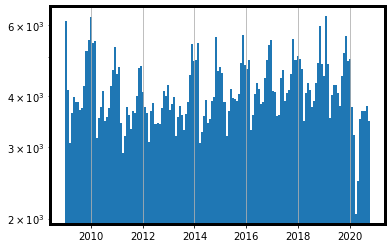

In [38]:
df_crashes['reportdate'].hist(bins=150)
plt.yscale('log')
plt.show()

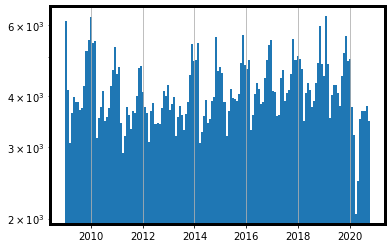

2009-01-02 00:00:00+00:00
2019-12-31 00:00:00+00:00
4015 days 00:00:00
We will normalize the crashes to an exposure time of 11 +- 0.5 years


<AxesSubplot:>

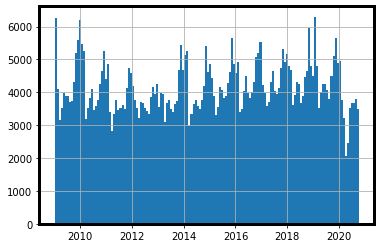

In [39]:
df_crashes['reportdate'].hist(bins=150)
plt.yscale('log')
plt.show()
print(df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].min())
print(df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].max())
print((df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].max())-\
      (df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]['reportdate'].min()))
print("We will normalize the crashes to an exposure time of 11 +- 0.5 years")

df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2022") ]['reportdate'].hist(bins=150)
# plt.yscale('log')

In [40]:
exposure_time = 11
exposure_time_up = 11.5
exposure_time_down = 10.5
df_crashes = df_crashes[(df_crashes['reportdate'] > "2009") &(df_crashes['reportdate'] < "2020") ]
# severe_columns = [x for x in df_crashes.columns if "FATAL" in x.upper() or "MAJOR" in x.upper()]
# df_crashes_severe = df_crashes[ pd.DataFrame.any(df_crashes[severe_columns].astype(int) > 0,axis=1) ]

# Major calculation section of the notebook - associating crashes to intersections
Loop over intersections and calculate the crash rates for all, severe, and fatal crashes per intersection.

In [41]:
df.head(3)

,node_id,point3857,lat,long,legs,way_lines,ramp_roads,bikepaths,footways,oneways,maxspeed,minspeed,surface_types,aadt,min_angle,second_min_angle,junction_geometry_type_id,junction_type_id,num_lanes,highway_type
0,30958903,POINT (-10196565.473 5124005.548),41.752692,-91.597306,3,0105000020110F000003000000010200000002000000A1...,0,0,0,0,None,None,None,50.0,112.200548,120.623423,2.0,1,NaN,residential
1,30993358,POINT (-10391248.056 5327062.849),43.099066,-93.346170,3,0105000020110F0000030000000102000000020000004A...,3,0,0,3,None,None,None,NaN,6.113267,173.601357,NaN,2,2.0,motorway_link
2,30993364,POINT (-10391112.202 5327066.004),43.099086,-93.344949,3,0105000020110F00000300000001020000000200000092...,0,0,0,0,70 mph,70 mph,None,NaN,5.056392,177.168803,2.0,1,2.0,motorway


In [42]:
# temp
# number_of_fatalities number_of_injuries number_of_major_injuries number_of_minor_injuries

In [89]:
# temp = df
temp_crashes = df_crashes.copy()
temp_crashes.geometry = df_crashes.geometry.buffer(15)
full = gpd.sjoin(df,temp_crashes,op='within')

major_crashes_lookup = full[['node_id_left','crash_severity']]\
[(full['number_of_vehicles_involved'].apply(int)>=2) & (full['crash_severity']>3)].groupby('node_id_left').count()/11#years

minor_crashes_lookup = full[['node_id_left','crash_severity']]\
[(full['number_of_vehicles_involved'].apply(int)>=2) & (full['crash_severity']<4)].groupby('node_id_left').count()/11#years



/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


#### Clean up the lookup tables

In [90]:
df.index = df.node_id
minor_crashes_lookup.index.rename('node_id',inplace=True)
minor_crashes_lookup.rename(columns={'crash_severity':"minor_crashes"},inplace=True)
major_crashes_lookup.index.rename('node_id',inplace=True)
major_crashes_lookup.rename(columns={'crash_severity':"major_crashes"},inplace=True)

In [91]:
final = df.join(minor_crashes_lookup).join(major_crashes_lookup)
# minor_crashes_lookup.loc[30993407]

### Count number of nearby intersections

In [92]:
temp_final = final.copy()
temp_final.geometry = temp_final.geometry.buffer(50)


In [93]:
# temp_final

In [94]:
final_self_join = gpd.sjoin(final,temp_final,op="within")

/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3338: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


In [95]:
average_aadt_lookup = final_self_join[['node_id_left','aadt_right']].groupby('node_id_left').mean()
node_density_lookup = final_self_join[['node_id_left','aadt_right']].groupby('node_id_left').count()


In [96]:
average_aadt_lookup.rename(columns={'node_id_left':'node_id',
                                    'aadt_right':'aadt_mean'},inplace=True)
node_density_lookup.rename(columns={'node_id_left':'node_id',
                                    'aadt_right':'node_density'},inplace=True)

In [97]:
final = final.join(average_aadt_lookup).join(node_density_lookup)

In [98]:
final["maxspeed"] = final['maxspeed'].apply(lambda x : str(x).replace("mph","").replace(" mph","").replace('35, 25 When Lights Flash','35').replace('15, 30','30') if x else np.nan).apply(lambda x: x if x != "24.14" else np.nan).astype(float)
final["minspeed"] = final['minspeed'].apply(lambda x : str(x).replace("mph","").replace(" mph","").replace('35, 25 When Lights Flash','35').replace('15, 30','30') if x else np.nan).apply(lambda x: x if x != "24.14" else np.nan).astype(float)



In [99]:
def surface_mapper(x):
    if x == 'nan':
        return np.nan
    else:
        return x.replace("[","").replace("]","").split(',')[0].replace("'","")

final['min_angle'] = final['min_angle'].apply(float)
final['second_min_angle'] = final['second_min_angle'].apply(float)
final['second_min_angle'] = final['second_min_angle'].apply(float)
final['surface_types'] = final['surface_types'].apply(str).apply(surface_mapper)

In [100]:
final['major_crashes'] = final.major_crashes.fillna(0)
final['minor_crashes'] = final.minor_crashes.fillna(0)

In [123]:
# df_int.head(50)
final.to_csv('iowa_df_before_modeling.csv')

In [101]:
# final.head()
# final = pd.read_csv('iowa_df_before_modeling.csv',index_col='node_id')
# del final['node_id.1']

In [130]:
target_var = "major_crashes"# "major_crashes"

X = final[[
        'legs',
       'ramp_roads',
       'oneways',
       'maxspeed',
       'minspeed',
       'surface_types',
       'aadt',
       'min_angle',
       'second_min_angle',
       'junction_geometry_type_id',
       'junction_type_id',
       'num_lanes',
       'highway_type',
       'aadt_mean',
       'node_density',
#        'minor_crashes',
#        'major_crashes'
      ]].copy()

# X = X[~X.aadt.isna().values]
# For some fields if there are blank entries we will take the most common as grouped by highway type

lookup_X = X.groupby('highway_type').mean()

# for i,row in X.iterrows():
#     if np.isnan(row['maxspeed']) and str(row['highway_type'])!='nan':
# #         print("blah")
# #         row['aadt'] = X[X.highway_type == row['highway_type']]['aadt'].mean()
# #         row['aadt_mean'] = X[X.highway_type == row['highway_type']]['aadt_mean'].mean()
#         row['maxspeed'] = lookup_X.loc[row['highway_type']]['maxspeed']
#         row['minspeed'] = lookup_X.loc[row['highway_type']]['minspeed']
#     if np.isnan(row['aadt']):
# #         print("blah")
# #         row['aadt'] = X[X.highway_type == row['highway_type']]['aadt'].mean()
# #         row['aadt_mean'] = X[X.highway_type == row['highway_type']]['aadt_mean'].mean()
#         row['aadt'] = lookup_X.loc[row['highway_type']]['aadt']
# #         row['minspeed'] = lookup_X.loc[row['highway_type']]['minspeed']
# #         row['surface_types'] = X[X.highway_type == row['highway_type']]['surface_types'].mode()


y = final[[target_var,
      ]] 

y = y.loc[X.index.values]

In [131]:
print("95% CL +/- using Poisson distribution " + str(np.sqrt( np.mean((y - y.mean())**2 ))*2))

95% CL +/- using Poisson distribution major_crashes    0.628217
dtype: float64


/Users/dylan.frizzell/dot/database_building/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3472: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


In [132]:
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import explained_variance_score


In [133]:

numeric_features = [
                    "oneways",
                    "maxspeed",
                    "minspeed",
                    "min_angle",
                    "second_min_angle",
                    "num_lanes",
                    "aadt",
                    'aadt_mean',
                    'node_density',
                   ]
numeric_transformer = Pipeline(
    steps=[
           ("imputer", SimpleImputer(strategy="median")),
#            ('poly',PolynomialFeatures()),
           ("scaler", StandardScaler()) , ]
)

categorical_features = [
        'legs',
       'ramp_roads',
       'surface_types',
       'junction_geometry_type_id',
        'junction_type_id',
       'highway_type',
      ]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocessor = ColumnTransformer(
    transformers=[
                ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

lr = [0.00001]
depth = [25,]
nodes = [50,]

experiments = []
for l in lr:
    for d in depth:
        for n in nodes:

            clf = Pipeline(
                steps=[("preprocessor", preprocessor),
                       ("model", 
                                MLPRegressor((n)*d,
                                                learning_rate_init=l,
#                                                  alpha=0.0001,
                                                random_state=1,
                                             early_stopping=True,
                                                max_iter=500)
                       )]
            )

            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
            clf.fit(X_train, np.ravel(y_train))
            score = clf.score(X_test, y_test)
            print("Explained variance: %.3f" % score)
#             explained_variance_score(y_test[target_var].values,clf.predict(X_test))
            
            experiments.append({'depth':d,
                                'learning rate': l,
                                'nodes': n,
                                'score': score})
# numeric_features = [
#                     "oneways",
#                     "maxspeed",
#                     "minspeed",
#                     "min_angle",
#                     "second_min_angle",
#                     "num_lanes",
#                     "aadt",
#                     'aadt_mean',
#                     'node_density',
#                    ]
# numeric_transformer = Pipeline(
#     steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler()) , ]
# )

# categorical_features = [
#         'legs',
#        'ramp_roads',
#        'surface_types',
#        'junction_geometry_type_id',
#         'junction_type_id',
#        'highway_type',
#       ]
# categorical_transformer = OneHotEncoder(handle_unknown="ignore")

# preprocessor = ColumnTransformer(
#     transformers=[
#                 ("num", numeric_transformer, numeric_features),
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )

# model = xgb.XGBRegressor(n_estimators=500,
#                          max_depth=5,
#                          reg_alpha=0.1,
#                          subsample=0.8
#                         )

# clf = Pipeline(
#     steps=[("preprocessor", preprocessor),
#            ("model", MLPRegressor((50,50,50,50),
#                                     learning_rate_init=0.001,
#                                     random_state=1,
#                                     max_iter=100))]
# )

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

# clf.fit(X_train, y_train)
# print("model score: %.3f" % clf.score(X_test, y_test))

Explained variance: 0.377


### The explained variance above 
describes the percent of the test set's variance that can be explained away with the model

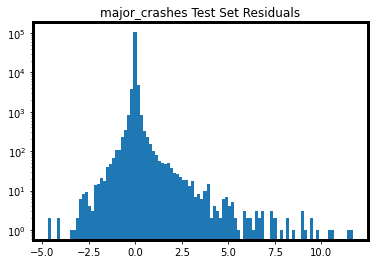

The 95% CL interval for the predictions can be estiamted to be +/- 0.523969469786943


In [134]:
plt.hist( (y_test[target_var].values-clf.predict(X_test)),bins=100)
plt.title(target_var +' Test Set Residuals')
plt.yscale("log")
plt.show()

print("The 95% CL interval for the predictions can be estiamted to be +/- " +\
      str(np.sqrt(np.mean( (y_test[target_var].values - clf.predict(X_test))**2 ) )*2.1))


### To make sure there is no overtraining,
We will also check the training set's residuals. If these two distributions have similar width, we can say there is negligible overtraining.

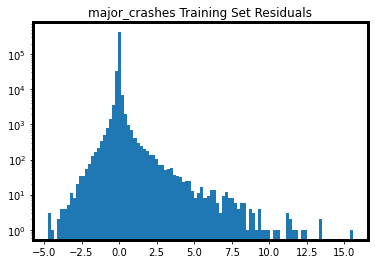

The 95% CL interval for the predictions can be estiamted to be +/- 0.5112623172738269


In [135]:
plt.hist(y_train[target_var].values-clf.predict(X_train),bins=100)
plt.title(target_var +' Training Set Residuals')
plt.yscale("log")
plt.show()
print("The 95% CL interval for the predictions can be estiamted to be +/- " +\
      str(np.sqrt(np.mean( (y_train[target_var].values - clf.predict(X_train))**2 ) )*2.1))

## Let's save the model, as this one is decent

In [136]:
final['predicted_'+target_var] = clf.predict(final)

# plt.bar(range(len(clf['model'].feature_importances_)), clf['model'].feature_importances_)
# plt.show()

In [122]:
# clf.predict(X_train[X_train.index==2612695632])
import joblib
joblib.dump(clf, 'iowa_trained_'+target_var+'.pkl') 

['iowa_trained_major_crashes.pkl']

In [137]:
# clf['model'].feature_importances_
# X_train
final.to_csv("iowa_case_study.csv")

In [36]:
# clf.predict(final)
# final.sort_values('major_crashes',ascending=False).head(50)

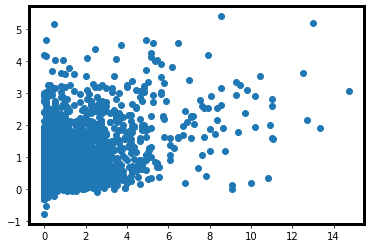

In [119]:
plt.scatter(y_test[target_var].values , clf.predict(X_test))
plt.show()

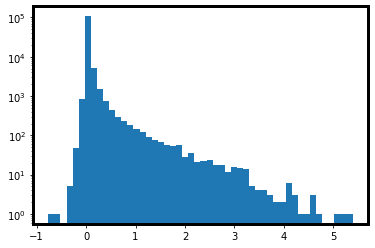

In [120]:
plt.hist(clf.predict(X_test),bins=50)
plt.yscale("log")
plt.show()

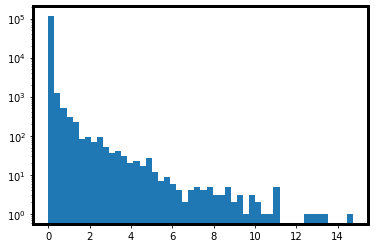

In [121]:
plt.hist(y_test[target_var].values,bins=50)
plt.yscale("log")
plt.show()